In [210]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import zero_one_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

## Supporting Files for This Project Are Included in the Project Repo

In [159]:
#os.chdir('supporting_files')

In [160]:
data = 'training_attack_types.txt'

In [161]:
category = defaultdict(list)
category['benign'].append('normal')

In [162]:
with open(data) as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

### Different Attack Types

In [163]:
#explore the different attack types
#category

In [164]:
# invert the dictionary to make it more manageable
attack_map = dict((v,k) for k in category for v in category[k])

In [165]:
#attack_map

### We need to read in the train and test data and create headers for the dataframe

In [166]:
train_f = 'KDDTrain+.txt'
test_f = 'KDDTest+.txt'

# categorical features
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [167]:
# train
training_df = pd.read_csv(train_f, names=header_names)
training_df['attack_category'] = training_df['attack_type'].map(lambda x: attack_map[x])
training_df.drop(['success_pred'], axis=1, inplace=True)

In [168]:
# test
testing_df = pd.read_csv(test_f, names=header_names)
testing_df['attack_category'] = training_df['attack_type'].map(lambda x: attack_map[x])
testing_df.drop(['success_pred'], axis=1, inplace=True)

### Visual Representation of the Types of Attacks and Their Relative Frequency

<Axes: ylabel='attack_type'>

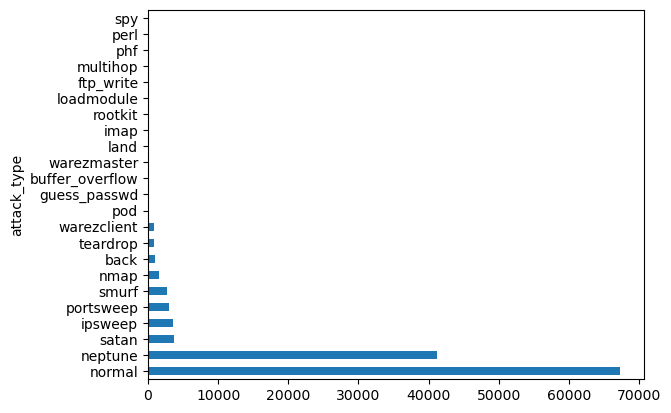

In [169]:
train_attack_type = training_df['attack_type'].value_counts()
train_attack_category = training_df['attack_category'].value_counts()
train_attack_type.plot(kind='barh')

<Axes: xlabel='attack_category'>

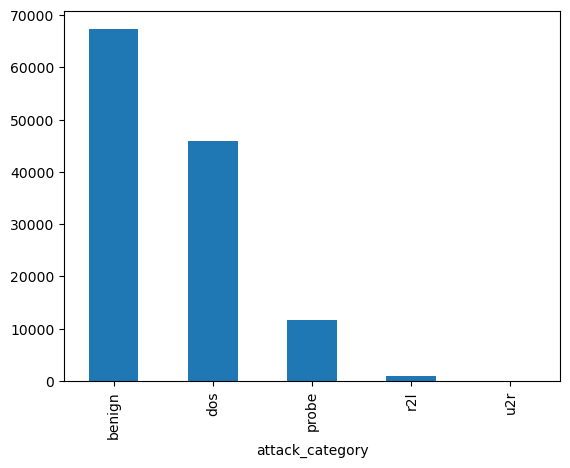

In [170]:
train_attack_category.plot(kind='bar')

### Preprocess the Data in Preparation for Model Training/Testing

In [171]:
train_Y = training_df['attack_category']
train_x = training_df.drop(['attack_category', 'attack_type'], axis=1)

test_Y  = testing_df['attack_category']
test_x  = testing_df.drop(['attack_category', 'attack_type'], axis=1)

In [172]:
feature_names = defaultdict(list)
names = 'kddcup.names'

In [173]:
with open(names, 'r') as f:
    for line in f.readlines()[1:]:
        name, nature = line.strip()[:-1].split(': ')
        feature_names[nature].append(name)

In [174]:
#feature_names

In [175]:
combined_df = pd.concat([train_x, test_x])

In [176]:
#combined_df.head()

In [177]:
continuous = feature_names['continuous']
continuous.remove('root_shell')

In [178]:
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

In [179]:
nominal = list(set(feature_names['symbolic']) - set(binary))

In [180]:
combined_dummy = pd.get_dummies(combined_df, columns=feature_names['symbolic'], drop_first=True)

In [181]:
# split into train and test
training_x = combined_dummy[:len(train_x)]
testing_x  = combined_dummy[len(train_x):]

In [182]:
dummy_list = list(set(train_x)-set(combined_dummy))

In [183]:
#training_x.describe()
#training_x['wrong_fragment'].describe()
training_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [184]:
durations = training_x['duration'].values.reshape(-1, 1)

In [185]:
# preprocess using standardization
start_time = time.time()
standard_scaler = StandardScaler().fit(durations)
standard_scaled_durations = standard_scaler.transform(durations)
end_time = time.time()
standard_time = end_time - start_time
pd.Series(standard_scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [186]:
standard_time

0.004591941833496094

In [187]:
# preprocess using normalization
start_time = time.time()
min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
end_time = time.time()
normal_time = end_time - start_time
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [188]:
normal_time

0.003052949905395508

In [189]:
# using standardization, scale the training and testing data
standard_scaler = StandardScaler().fit(training_x[continuous])
training_x[continuous] = standard_scaler.transform(training_x[continuous])
testing_x[continuous] = standard_scaler.transform(testing_x[continuous])

### Explore Runtime and Accuracy Using a Supervised Learning Model

In [195]:
# time to classify --> 5 class classification problem (benign, u2r, r2l, dos, probe)
# supervised learning model
# random forest
start_time = time.time()
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(training_x, train_Y)
prediction_y = classifier.predict(testing_x)
end_time = time.time()
decision_supervised_elapsed_time = end_time - start_time
accuracy = 1 - zero_one_loss(test_Y, prediction_y)

In [196]:
# how accurate is the supervised learning classifier
round(accuracy * 100, 2) 

43.53

In [197]:
# how long did the random forests take to run on ~126,000 records
decision_supervised_elapsed_time

0.9171187877655029

### Explore Runtime and Accuracy Using an Unsupervised Learning Model

In [198]:
# unsupervised learning model
kmeans = KMeans(n_clusters=5).fit(training_x)

In [199]:
prediction_y = kmeans.predict(testing_x)

In [200]:
print(pd.Series(prediction_y).value_counts())

1    13713
3     5238
0     2086
4     1505
2        2
Name: count, dtype: int64


In [201]:
len(training_x.columns)

119

In [202]:
pca = PCA(n_components=2)
training_x_pca = pca.fit_transform(training_x)

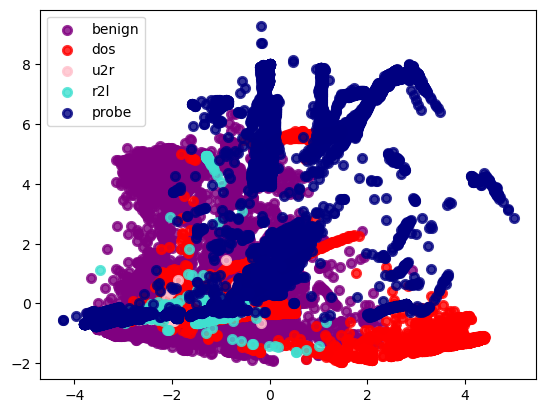

In [203]:
plt.figure()
colors = ['purple', 'red', 'pink', 'turquoise', 'navy']
for color, cat in zip(colors, category.keys()):
    plt.scatter(training_x_pca[train_Y==cat, 0],
    training_x_pca[train_Y==cat, 1],
               color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [204]:
start_time = time.time()
kmeans = KMeans(n_clusters=5, random_state=17).fit(training_x)
end_time = time.time()
kmeans_unsupervised_elapsed_time = end_time - start_time

In [205]:
# how long did kmeans take to run on ~126,000 records
kmeans_unsupervised_elapsed_time

3.3505680561065674

In [206]:
kmeans_y = kmeans.labels_

In [125]:
silhouette_avg = silhouette_score(training_x, kmeans_y)

In [207]:
len(training_x)

125973

In [208]:
# silhouette score ranges from -1 to 1
silhouette_avg

0.3979398639556127

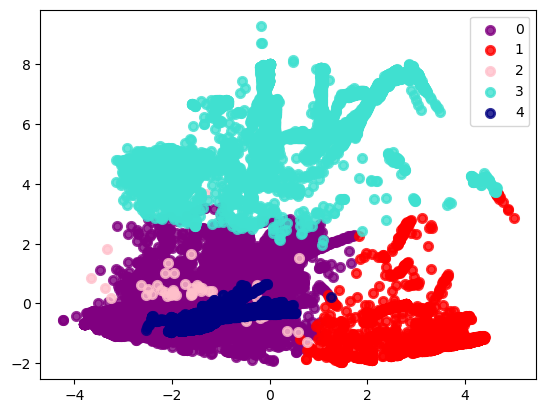

In [209]:
plt.figure()
colors = ['purple', 'red', 'pink', 'turquoise', 'navy']
for color, cat in zip(colors, range(5)):
    plt.scatter(training_x_pca[kmeans_y==cat, 0],
    training_x_pca[kmeans_y==cat, 1],
               color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()